# Sentiment Analysis of Movies on IMDB using Web Scraping and Vader Analysis
This script is used to analyze sentiment towards a movie based on its reviews. \
The script using web scrapping to retrieve review data automatically from the IMDB website, and using Vader to analyze the sentiment

## Data Acquisition

### Import Library and Initalize

In [1]:
# Import Library
import numpy as np
import pandas as pd
from scrapy.selector import Selector
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

# initialize Lemmatizer and stop words
lm = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Scrape the data from IMDB website

In [2]:
# Set the link to review page from movies that you want on imdb
link = 'https://www.imdb.com/title/tt9426210/reviews?ref_=tt_urv'

# Initializing webdriver chrome and getting the link
driver = webdriver.Chrome()
driver.get((link))
time.sleep(1)
print(driver.title)

Weathering with You (2019) - Weathering with You (2019) - User Reviews - IMDb


In [3]:
# Declare Selector to get total reviews on that movie
sel = Selector(text = driver.page_source)
review_counts = sel.css('.lister .header span::text').extract_first().replace('.','').split(' ')[0]

# Because on the website only show 25 data, need to get total pages
more_review_pages = int(int(review_counts)/25)

In [4]:
# looping so we can get all of the data
for i in range(more_review_pages):
    try:
        #click Load more button so the page will show all of the data
        css_selector = 'load-more-trigger'
        driver.find_element(By.ID, css_selector).click()
        print(f"Load review {i+1} of {more_review_pages}: Success")

        # delay on it based on your internet connection, I delay it 10 secnd coz my Internet is slow LOL
        time.sleep(10)
    except:
        print(f"Load review {i+1} of {more_review_pages}: Fail")
        pass

Load review 1 of 11: Success
Load review 2 of 11: Success
Load review 3 of 11: Success
Load review 4 of 11: Success
Load review 5 of 11: Success
Load review 6 of 11: Success
Load review 7 of 11: Success
Load review 8 of 11: Success
Load review 9 of 11: Success
Load review 10 of 11: Success
Load review 11 of 11: Success


In [5]:
# Get all comment review data
error_msg_list = []
review_all_list = []
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

for d in reviews:
    try:
        sel2 = Selector(text = d.get_attribute('innerHTML'))
        try:
            # Get comment
            review = sel2.css('.text.show-more__control::text').extract()
            review = ', '.join(review)            
        except:
            review = np.NaN
        try:
            # Get title of the comment
            review_title = sel2.css('a.title::text').extract_first()
        except:
            review_title = np.NaN
            
        if str(review) == "nan":
            review_all = review_title
        elif str(review_title)== "nan":
            review_all = review
        else:
            review_all = review_title + ". " + review
 
        review_all_list.append(review_all)
    except Exception as e:
        error_msg_list.append(e)
        
review_df = pd.DataFrame({
    'Review':review_all_list
    })

In [6]:
# Final data review from the web
review_df

Review
0     Yet another poignant story from the acclaimed...
1     slight story powered by stunning water animat...
2     Beautiful animation and visualization.\n. I'm...
3     Masterful anime film\n. One of the best exper...
4     sweet\n. Hina is literally sunshine. She walk...
..                                                 ...
283   This movie touched me\n. I made an account ju...
284   I adored it.\n. I was introduced to anime and...
285   beautiful new animation movie\n. Would give i...
286   One of a kind\n. "Weathering with you" was tr...
287   its a metaphor!!\n. Seriously, I understand i...

[288 rows x 1 columns]

## Data Processing and Cleaning

In [7]:
# Processing and cleaning the data
def change_format(review):
    # Change to lower
    review = review.lower()
    
    # Removing special characters
    review = re.sub('^a-zA-Z0-9',' ',review)

    # Remove html tags
    review = re.sub('<.*?>',' ',review)

    # Remove punctuation
    review = "".join([x for x in review if x not in string.punctuation])
    
    # Lemmatization and stopwords
    review = review.split()
    review =[lm.lemmatize(x) for x in review if x not in stop_words]
    review = " ".join(review)
    
    return review
    
review_df['review_lemme']=review_df['Review'].apply(change_format)

In [9]:
# Final data after cleaning in column review_lemme
review_df

Review  \
0     Yet another poignant story from the acclaimed...   
1     slight story powered by stunning water animat...   
2     Beautiful animation and visualization.\n. I'm...   
3     Masterful anime film\n. One of the best exper...   
4     sweet\n. Hina is literally sunshine. She walk...   
..                                                 ...   
283   This movie touched me\n. I made an account ju...   
284   I adored it.\n. I was introduced to anime and...   
285   beautiful new animation movie\n. Would give i...   
286   One of a kind\n. "Weathering with you" was tr...   
287   its a metaphor!!\n. Seriously, I understand i...   

                                          review_lemme  
0    yet another poignant story acclaimed anime art...  
1    slight story powered stunning water animation ...  
2    beautiful animation visualization im intereste...  
3    masterful anime film one best experience ever ...  
4    sweet hina literally sunshine walk rooftop por...  
..                                                 ...  
283  movie touched made account comment movie huge ...  
284  adored introduced anime manga via collegeaged ...  
285  beautiful new animation movie would give 87 is...  
286  one kind weathering truly charming inspiring g...  
287  metaphor seriously understand movie wishywashy...  

[288 rows x 2 columns]

## Sentiment Analysis Implementation

In [10]:
# Sentiment Analysis using Vader
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def vader_analysis(compound):
    compound = compound["compound"]
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'

review_df['scores']=review_df.apply(lambda x: sia.polarity_scores(x['review_lemme']), axis=1)
review_df['sentiment']=review_df.apply(lambda x: vader_analysis(x['scores']), axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# Final data after Sentiment analysisi implementation
review_df

Review  \
0     Yet another poignant story from the acclaimed...   
1     slight story powered by stunning water animat...   
2     Beautiful animation and visualization.\n. I'm...   
3     Masterful anime film\n. One of the best exper...   
4     sweet\n. Hina is literally sunshine. She walk...   
..                                                 ...   
283   This movie touched me\n. I made an account ju...   
284   I adored it.\n. I was introduced to anime and...   
285   beautiful new animation movie\n. Would give i...   
286   One of a kind\n. "Weathering with you" was tr...   
287   its a metaphor!!\n. Seriously, I understand i...   

                                          review_lemme  \
0    yet another poignant story acclaimed anime art...   
1    slight story powered stunning water animation ...   
2    beautiful animation visualization im intereste...   
3    masterful anime film one best experience ever ...   
4    sweet hina literally sunshine walk rooftop por...   
..                                                 ...   
283  movie touched made account comment movie huge ...   
284  adored introduced anime manga via collegeaged ...   
285  beautiful new animation movie would give 87 is...   
286  one kind weathering truly charming inspiring g...   
287  metaphor seriously understand movie wishywashy...   

                                                scores sentiment  
0    {'neg': 0.015, 'neu': 0.755, 'pos': 0.23, 'com...  Positive  
1    {'neg': 0.047, 'neu': 0.513, 'pos': 0.44, 'com...  Positive  
2    {'neg': 0.058, 'neu': 0.627, 'pos': 0.315, 'co...  Positive  
3    {'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...  Positive  
4    {'neg': 0.017, 'neu': 0.501, 'pos': 0.483, 'co...  Positive  
..                                                 ...       ...  
283  {'neg': 0.055, 'neu': 0.43, 'pos': 0.515, 'com...  Positive  
284  {'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'comp...  Positive  
285  {'neg': 0.055, 'neu': 0.706, 'pos': 0.239, 'co...  Positive  
286  {'neg': 0.081, 'neu': 0.375, 'pos': 0.545, 'co...  Positive  
287  {'neg': 0.116, 'neu': 0.59, 'pos': 0.293, 'com...  Positive  

[288 rows x 4 columns]

## Results Visualization

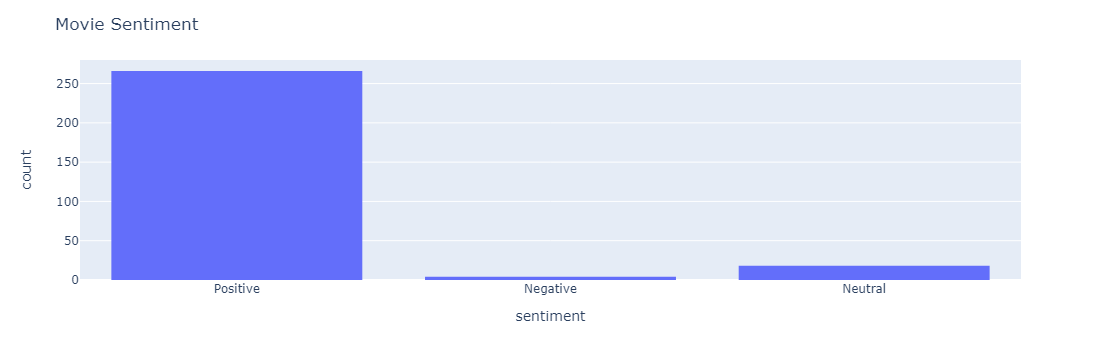

In [11]:
# Total sentiment
fig = px.histogram(review_df, x="sentiment")
fig.update_layout(title_text='Movie Sentiment')
fig.show()

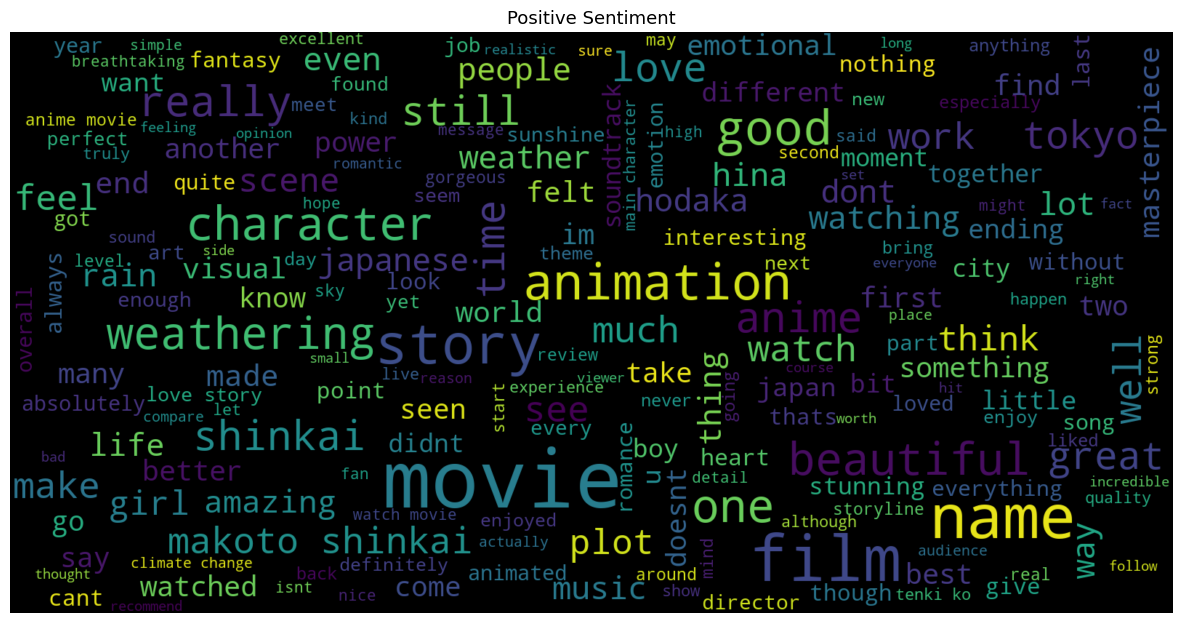

In [12]:
# Wordcloud Positive setiment
consolidated=' '.join(word for word in review_df['review_lemme'][review_df['sentiment']== "Positive"].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.title("Positive Sentiment", fontsize=13)
plt.show()

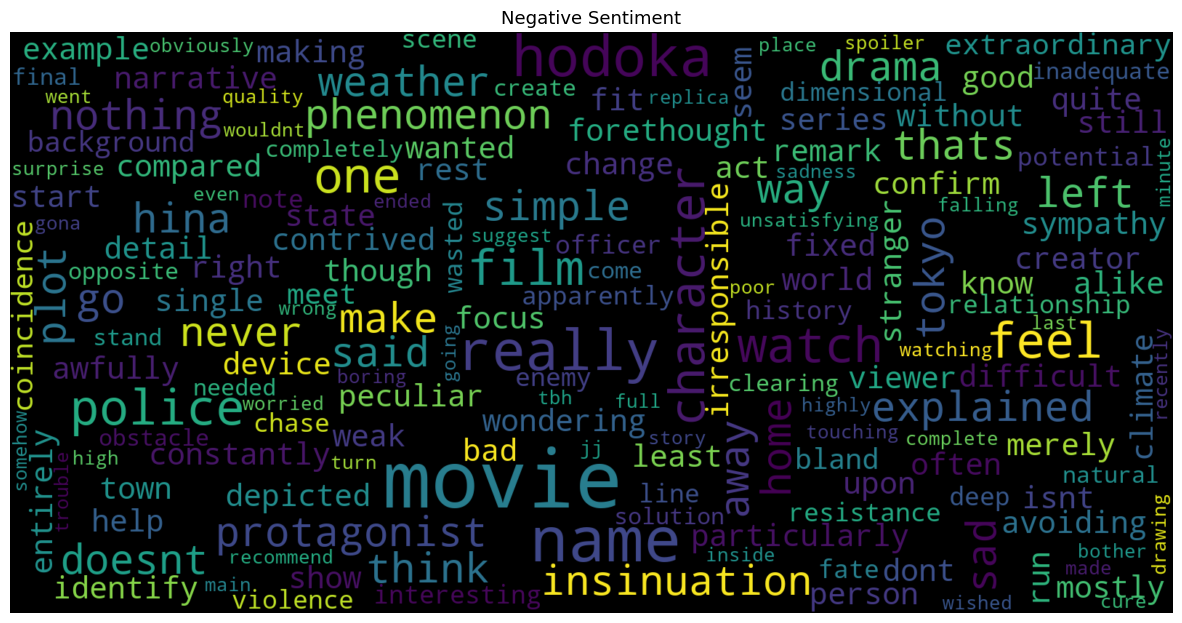

In [13]:
# Wordcloud Negative setiment
consolidated=' '.join(word for word in review_df['review_lemme'][review_df['sentiment']== "Negative"].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.title("Negative Sentiment", fontsize=13)
plt.show()

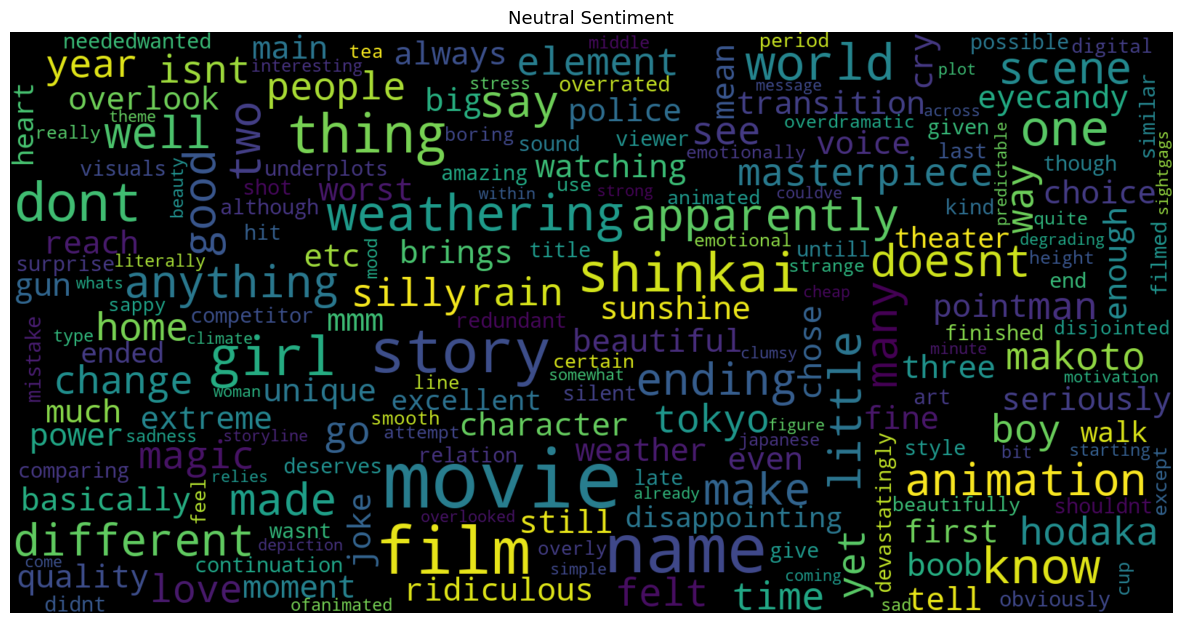

In [14]:
# Wordcloud Neutral setiment
consolidated=' '.join(word for word in review_df['review_lemme'][review_df['sentiment']== "Neutral"].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.title("Neutral Sentiment", fontsize=13)
plt.show()

## Write-up
So the project is used to find out the sentiment towards a movie. This project retrieves data from IMDB website using the web scrapping method. After obtaining the data, the data was analyzed using the Vader method to determine positive, negative and neutral reviews.
And finally the data is visualized based on the number of positive, negative and neutral reviews and a word cloud is created based on the words that appear the most.